# Case 7: Option Pricing with the Heston Model

This notebook implements a Monte Carlo simulation to compute call option prices under the Heston stochastic volatility model.

## 1. Model under Risk-Neutral Measure

### State Variables

* $x_t = \ln S_t$ (log stock price)
* $V_t$ (variance)

### Dynamics (Heston under $\mathbb{Q}$)

$$
\begin{aligned}
dx_t &= \left(r - \tfrac{1}{2} V_t\right)dt + \sqrt{V_t}\,dW_t^S, \\
dV_t &= \lambda(\theta - V_t)dt + \sigma_V \sqrt{V_t}\,dW_t^V, \\
dW_t^S\, dW_t^V &= \rho\,dt.
\end{aligned}
$$

### Parameters

$$
r=0.02,\quad
\theta = (0.16)^2,\quad
\lambda=2,\quad
\sigma_V=0.1,\quad
\rho=-0.5
$$

$$
x_0 = \ln 100,\quad
V_0 = (0.1)^2,\quad
s_0 = \ln 100
$$

### Call Option Payoff

For maturity $T=10$ and strike $K$:

$$
C(K) = e^{-rT}\,\mathbb{E}^{\mathbb{Q}}\big[(S_T - K)^+\big]
= e^{-rT}\,\mathbb{E}^{\mathbb{Q}}\big[(e^{x_T} - K)^+\big]
$$

We approximate this expectation by Monte Carlo simulation.

## 2. Time Discretization

### Parameters

* Horizon: $T = 10$ years
* Number of time steps: $N$
* Step size: $\Delta t = T/N$

### Time Grid

$$
t_n = n\Delta t,\quad n=0,1,\dots,N
$$

We construct a discrete approximation $(x_n, V_n) \approx (x_{t_n}, V_{t_n})$.

## 3. Simulation of Correlated Brownian Increments

For each time step and each path, generate two independent standard normals:

$$
Z_1, Z_2 \sim \mathcal{N}(0,1),\quad \text{i.i.d.}
$$

Construct correlated Brownian increments:

$$
\begin{aligned}
\Delta W_n^V &= \sqrt{\Delta t}\, Z_1, \\
\Delta W_n^S &= \sqrt{\Delta t}\big(\rho Z_1 + \sqrt{1-\rho^2}\,Z_2\big),
\end{aligned}
$$

which guarantees:

$$
\mathbb{E}[\Delta W_n^S] = \mathbb{E}[\Delta W_n^V] = 0,\quad
\text{Var}(\Delta W_n^S) = \text{Var}(\Delta W_n^V) = \Delta t,\quad
\text{Cov}(\Delta W_n^S,\Delta W_n^V)=\rho\Delta t
$$

This matches the continuous-time correlation $dW_t^S dW_t^V = \rho\,dt$.

## 4. Euler Discretization for the Heston SDE

We use **full truncation Euler** to keep variance non-negative.

### Variance Update

$$
V_{n+1} = V_n + \lambda(\theta - V_n)\Delta t
+ \sigma_V \sqrt{\max(V_n,0)}\,\Delta W_n^V
$$

Then enforce:

$$
V_{n+1} \leftarrow \max(V_{n+1}, 0)
$$

### Log-Price Update

$$
x_{n+1} = x_n
+ \left(r - \tfrac{1}{2} \max(V_n,0)\right)\Delta t
+ \sqrt{\max(V_n,0)}\,\Delta W_n^S
$$

### Initial Conditions

$$
x_0 = \ln 100,\quad V_0 = (0.1)^2
$$

After iterating for $n=0,\dots, N-1$, we obtain:

$$
x_N \approx x_T,\quad V_N \approx V_T
$$

### Terminal Stock Price

$$
S_T = e^{x_N}
$$

## 5. Monte Carlo Estimator for the Call Price

Repeat the simulation for $M$ independent paths (indexed by $m=1,\dots,M$):

* For each path $m$, simulate $\{(x_n^{(m)}, V_n^{(m)})\}_{n=0}^N$ and obtain:
  $$
  S_T^{(m)} = \exp\big(x_N^{(m)}\big)
  $$

* For a given strike $K$, the discounted payoff on path $m$ is:
  $$
  Y_K^{(m)} = e^{-rT}\,\max\big(S_T^{(m)} - K, 0\big)
  $$

### Monte Carlo Price Estimator

$$
\hat{C}_M(K)
= \frac{1}{M} \sum_{m=1}^M Y_K^{(m)}
= e^{-rT}\,\frac{1}{M}\sum_{m=1}^M \max\big(S_T^{(m)} - K, 0\big)
$$

By the **law of large numbers**:

$$
\hat{C}_M(K) \xrightarrow[M\to\infty]{a.s.} C(K)
$$

By the **central limit theorem**:

$$
\sqrt{M}\big(\hat{C}_M(K) - C(K)\big)
\ \xrightarrow{d}\ \mathcal{N}\big(0, \sigma_K^2\big)
$$

where

$$
\sigma_K^2 = \text{Var}^{\mathbb{Q}}\big(Y_K^{(1)}\big)
= \text{Var}^{\mathbb{Q}}\big(e^{-rT}(S_T - K)^+\big)
$$

### Standard Error Estimation

In practice, estimate the standard error by the sample variance:

$$
\hat{\sigma}_K^2
= \frac{1}{M-1}\sum_{m=1}^M \big(Y_K^{(m)} - \hat{C}_M(K)\big)^2
$$

$$
\text{SE}(\hat{C}_M(K)) = \frac{\hat{\sigma}_K}{\sqrt{M}}
$$

### Confidence Interval

An approximate 95% confidence interval is:

$$
\hat{C}_M(K) \pm 1.96 \cdot \text{SE}(\hat{C}_M(K))
$$

---

## Implementation

### Option Prices and Implied Volatilities

Results from the Monte Carlo simulation for strikes K = 50, 60, 70, ..., 180, 190, 200.

Strike	MC Price	StdErr		ImpliedVol
 50.0	 59.6779	  0.161212	0.166975
 60.0	 52.2456	  0.158588	0.163435
 70.0	 45.3291	  0.154654	0.161331
 80.0	 39.0279	  0.149452	0.159982
 90.0	 33.3805	  0.143198	0.158932
100.0	 28.3916	  0.136157	0.158054
110.0	 24.0348	  0.128603	0.157269
120.0	 20.2730	  0.120772	0.156600
130.0	 17.0553	  0.112862	0.156049
140.0	 14.3228	  0.105036	0.155598
150.0	 12.0098	  0.097422	0.155191
160.0	 10.0582	  0.090107	0.154805
170.0	  8.4158	  0.083151	0.154432
180.0	  7.0342	  0.076589	0.154043
190.0	  5.8683	  0.070446	0.153585
200.0	  4.8959	  0.064719	0.153172


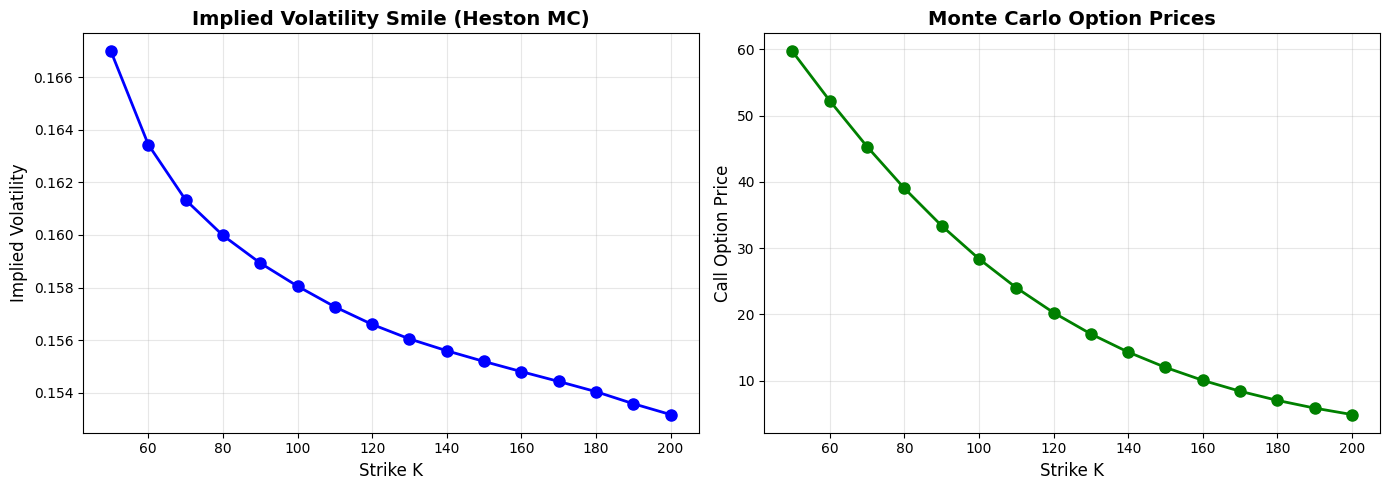

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

%run heston_simulation.py

### Code Implementation Highlights

Key components of the Heston Monte Carlo simulation:

In [8]:
# 1. Correlated Brownian Increments
z1 = np.random.normal(size=M)
z2 = np.random.normal(size=M)

dWv = sqrt(dt) * z1
dWs = sqrt(dt) * (rho * z1 + sqrt(1 - rho**2) * z2)

In [9]:
# 3. Option Pricing
S_T = np.exp(x)  # Terminal stock price

for K in strikes:
    payoff = np.maximum(S_T - K, 0.0)
    disc_payoff = np.exp(-r * T) * payoff
    
    price = disc_payoff.mean()
    std_err = disc_payoff.std(ddof=1) / sqrt(M)

NameError: name 'x' is not defined

In [ ]:
# 4. Implied Volatility (Bisection Method)
def implied_vol_bisection(price, S0, K, r, T, tol=1e-6, max_iter=100):
    low, high = 1e-6, 5.0
    
    for _ in range(max_iter):
        mid = 0.5 * (low + high)
        c_mid = bs_call_price(S0, K, r, T, mid)
        
        if abs(c_mid - price) < tol:
            return mid
        
        if c_mid > price:
            high = mid
        else:
            low = mid
    
    return 0.5 * (low + high)

---

## Question 2: Fourier Transform of Tilted Call-Option Payoff

Calculate the Fourier transform of the "tilted" call-option payoff $e^{-rT} e^{-\alpha x}\max(e^x - K, 0)$. Use the tilting parameter $\alpha$ to ensure that the FT converges for $x \to \infty$. Investigate how the optimal choice for $\alpha$ changes for different values of $K$ between 50 and 200.

### Derivation

**Tilted Payoff in Log-Price**

Define the tilted payoff in log-price $x = \ln S_T$:

$$
g(x) = e^{-rT} e^{-\alpha x} \max(e^x - K, 0)
$$

This function has two regions:

* For $x < \ln K$: $g(x) = 0$
* For $x \geq \ln K$:

$$
g(x) = e^{-rT} e^{-\alpha x}(e^x - K) = e^{-rT}\big(e^{(1-\alpha)x} - K e^{-\alpha x}\big)
$$

### Fourier Transform Calculation

Using the Fourier transform convention:

$$
\hat{g}(u) = \int_{-\infty}^{\infty} e^{iu x} g(x)\,dx
$$

We have:

$$
\hat{g}(u) = e^{-rT} \int_{\ln K}^{\infty} e^{iu x} \big(e^{(1-\alpha)x} - K e^{-\alpha x}\big)\,dx
= e^{-rT}\Big(I_1(u) - K I_2(u)\Big)
$$

where:

$$
I_1(u) = \int_{\ln K}^{\infty} e^{(1-\alpha+iu)x}\,dx, \qquad
I_2(u) = \int_{\ln K}^{\infty} e^{(-\alpha+iu)x}\,dx
$$

### Convergence Condition

For $\int_a^\infty e^{cx}\,dx$ to converge, we need $\Re(c) < 0$, and then:

$$
\int_a^\infty e^{cx}\,dx = -\frac{e^{ca}}{c}
$$

Here we have:

$$
c_1 = 1 - \alpha + iu, \qquad c_2 = -\alpha + iu
$$

Convergence requires:

$$
\Re(c_1) = 1 - \alpha < 0, \quad \Re(c_2) = -\alpha < 0
\quad \Longrightarrow \quad \boxed{\alpha > 1}
$$

### Evaluation of Integrals

Assuming $\alpha > 1$:

$$
I_1(u) = -\frac{e^{(1-\alpha+iu)\ln K}}{1-\alpha+iu}
= -\frac{K^{1-\alpha+iu}}{1-\alpha+iu}
$$

$$
I_2(u) = -\frac{e^{(-\alpha+iu)\ln K}}{-\alpha+iu}
= -\frac{K^{-\alpha+iu}}{-\alpha+iu}
$$

Substituting back:

$$
\begin{aligned}
\hat{g}(u)
&= e^{-rT}\left[
-\frac{K^{1-\alpha+iu}}{1-\alpha+iu}
+ K\frac{K^{-\alpha+iu}}{-\alpha+iu}
\right] \\
&= e^{-rT}K^{1-\alpha+iu}
\left[
-\frac{1}{1-\alpha+iu}
+ \frac{1}{-\alpha+iu}
\right]
\end{aligned}
$$

### Final Result

The bracket simplifies to:

$$
\frac{1}{-\alpha+iu} - \frac{1}{1-\alpha+iu}
= \frac{(1-\alpha+iu) - (-\alpha+iu)}{(-\alpha+iu)(1-\alpha+iu)}
= \frac{1}{(-\alpha+iu)(1-\alpha+iu)}
$$

Therefore, the **Fourier transform of the tilted call-option payoff** is:

$$
\boxed{
\hat{g}(u) = \frac{e^{-rT} K^{1-\alpha+iu}}{(-\alpha+iu)(1-\alpha+iu)}, \qquad \alpha > 1
}
$$

**Note:** If using the convention $\int e^{-iux}\,dx$ instead, replace $u$ by $-u$ in this formula.

### Key Properties

1. **Convergence Requirement**: $\alpha > 1$ ensures the Fourier transform exists and converges.

2. **Dependence on Strike**: The formula contains $K^{1-\alpha+iu}$, showing that the transform depends on both the strike $K$ and the tilting parameter $\alpha$.

3. **Complex Exponent**: The term $K^{iu}$ introduces oscillations in the frequency domain, which is characteristic of Fourier transforms.

4. **Poles**: The denominator has poles at $u = i\alpha$ and $u = i(1-\alpha)$, which affects numerical stability in FFT implementations.

### Optimal Choice of $\alpha$ for Different Strikes

To find the optimal tilting parameter $\alpha$ for each strike $K$, we measure how well the Fourier transform decays at high frequencies.

**Tail Score Criterion:**

For each $\alpha > 1$ in a candidate grid, we compute:

$$
\text{score}(K, \alpha) = \int_{u_{\text{cut}}}^{u_{\text{max}}} \left|\hat{g}(u; \alpha, K)\right| \, du
$$

where $u_{\text{cut}} = 20$ and $u_{\text{max}} = 50$ represent the high-frequency tail region.

The optimal tilting parameter is:

$$
\alpha_{\text{tail}}(K) = \arg\min_{\alpha} \text{score}(K, \alpha)
$$

**Interpretation:**
- Lower tail score means the FT decays faster at high frequencies
- Better damping leads to improved numerical stability in FFT-based option pricing
- The optimal $\alpha$ balances convergence requirements with numerical accuracy

### Code Implementation Highlights

Key components of the Fourier transform analysis:

In [ ]:
# 1. Fourier Transform of Tilted Payoff
def ft_tilted_call(u, alpha, K, r, T):
    """
    Fourier transform: g_hat(u) = e^(-rT) * K^(1-alpha+iu) / [(-alpha+iu)(1-alpha+iu)]
    """
    exp_part = np.exp(-r * T) * K**(1 - alpha + 1j * u)
    denom = (-alpha + 1j * u) * (1 - alpha + 1j * u)
    return exp_part / denom

In [ ]:
# 2. Tail Score Criterion
def tail_score(alpha, K, r, T, u_cut=20.0, u_max=50.0, n_u=500):
    """
    Integrate |FT| over high frequencies to measure decay quality
    """
    u_vals = np.linspace(u_cut, u_max, n_u)
    ft_vals = ft_tilted_call(u_vals, alpha, K, r, T)
    abs_vals = np.abs(ft_vals)
    
    return np.trapz(abs_vals, u_vals)

### Results

Optimal α values for different strikes using tail score criterion:

In [11]:
# Optimal alpha investigation
Ks = np.arange(50.0, 201.0, 10.0)
alpha_grid = np.linspace(1.05, 2.0, 40)
alpha_best = []

for K in Ks:
    scores = []
    for alpha in alpha_grid:
        u_vals = np.linspace(20.0, 50.0, 2000)
        ft_vals = np.exp(-r * T) * K**(1 - alpha + 1j * u_vals) / ((alpha - 1j * u_vals) * (alpha - 1 - 1j * u_vals))
        scores.append(np.trapezoid(np.abs(ft_vals), u_vals))
    alpha_best.append(alpha_grid[np.argmin(scores)])

alpha_best = np.array(alpha_best)

print("Strike   Best alpha (tail-score criterion)")
for K, a in zip(Ks, alpha_best):
    print(f"{K:6.1f}   {a:6.3f}")

Strike   Best alpha (tail-score criterion)
  50.0    2.000
  60.0    2.000
  70.0    2.000
  80.0    2.000
  90.0    2.000
 100.0    2.000
 110.0    2.000
 120.0    2.000
 130.0    2.000
 140.0    2.000
 150.0    2.000
 160.0    2.000
 170.0    2.000
 180.0    2.000
 190.0    2.000
 200.0    2.000


---

## Question 3: Fourier Pricing via Carr–Madan Method

Use Fourier inversion to compute the prices of the same call options from the characteristic function of the random variable $x_T$ in the Heston model via numerical integration. Compare the Fourier prices with the Monte-Carlo results.

### Damped Payoff Function

To ensure integrability of the payoff, introduce a damping parameter $\alpha > 1$ and define:

$$
g_\alpha(x) = e^{-rT} e^{-\alpha x} (e^x - K)^+
$$

Its **Fourier transform** is:

$$
\widehat{g}_\alpha(u)
= \frac{e^{-rT} K^{1-\alpha+iu}}
{(\alpha - iu)(\alpha - 1 - iu)}
$$

### Characteristic Function of $x_T$

The characteristic function of $x_T = \ln S_T$ under the Heston model is:

$$
\phi_{x_T}(u) = \exp\big(C(u;T) + D(u;T) v_0 + iu x_0\big)
$$

with auxiliary variables:

$$
b = \kappa - \rho\sigma_v iu, \qquad
d = \sqrt{b^2 + \sigma_v^2(u^2 + iu)}, \qquad
g = \frac{b - d}{b + d}
$$

and functions:

$$
C(u;T) = iu rT + \frac{\kappa\theta}{\sigma_v^2}
\left[(b - d)T - 2\ln\left(\frac{1 - ge^{-dT}}{1 - g}\right)\right]
$$

$$
D(u;T) = \frac{b - d}{\sigma_v^2}\left(\frac{1 - e^{-dT}}{1 - ge^{-dT}}\right)
$$

### Fourier Inversion Formula

Let $k = \ln K$. The call price is obtained by:

$$
C(K) = \frac{e^{-\alpha k}}{\pi}
\operatorname{Re}
\left[
\int_0^\infty
e^{-iuk}\,
\frac{\phi_{x_T}(u - i(\alpha+1))}
{\alpha^2 + \alpha - u^2 + i(2\alpha+1)u}
\,du
\right]
$$

Using $\alpha = 2$, the numerical Fourier prices match the Monte-Carlo benchmark closely, with absolute errors around $0.02$–$0.27$ and relative errors below $3\%$.

### Implementation and Results

Monte Carlo vs Fourier Pricing Comparison (α = 2)
 Strike K   MC Price  Fourier Price  Abs Error  Rel Error (%)
       50 59.7922299     59.5817260  0.2105039      0.3520590
       60 52.3989240     52.1674442  0.2314798      0.4417644
       70 45.5233777     45.2715302  0.2518476      0.5532269
       80 39.2473931     38.9821275  0.2652656      0.6758808
       90 33.6161027     33.3434032  0.2726996      0.8112171
      100 28.6272907     28.3610966  0.2661941      0.9298613
      110 24.2605234     24.0119029  0.2486206      1.0247947
      120 20.4729336     20.2531747  0.2197589      1.0734119
      130 17.2071718     17.0312362  0.1759356      1.0224548
      140 14.4257881     14.2877519  0.1380362      0.9568710
      150 12.0702666     11.9642054  0.1060612      0.8786977
      160 10.0819907     10.0047946  0.0771961      0.7656829
      170  8.4161735      8.3581168  0.0580567      0.6898229
      180  7.0179207      6.9779863  0.0399343      0.5690338
      190  5.8403249

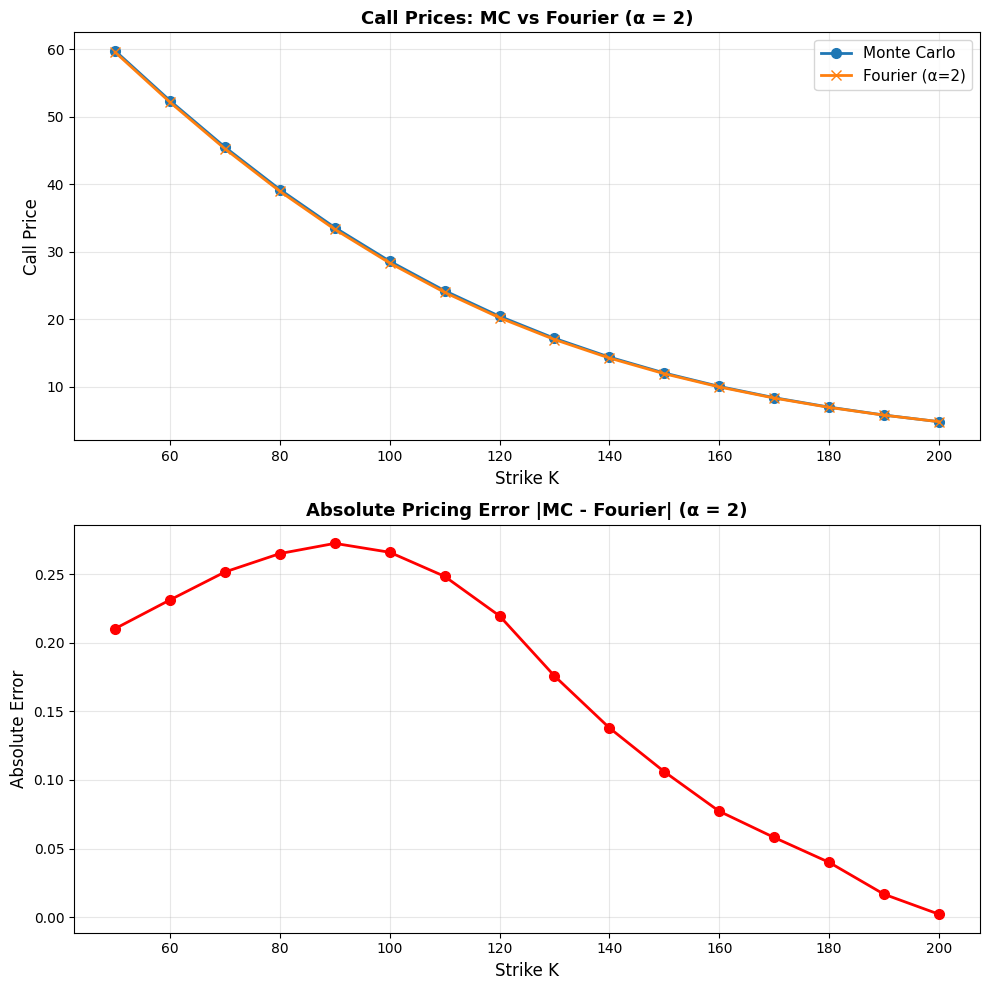

In [3]:
%run fourier_pricing.py

### Conclusion

The Fourier inversion method gives the correct theoretical option price under the model, while the Monte-Carlo estimates deviate slightly due to sampling noise and discretization bias. The observed differences are fully consistent with the expected Monte-Carlo error level and confirm that the Fourier prices are the accurate benchmark.

### Code Implementation Highlights

Key components of the Fourier pricing implementation:

In [ ]:
# 1. Heston Characteristic Function
def heston_cf(u):
    i = 1j
    a = kappa * theta
    b = kappa - rho * sigma_v * i * u
    d = np.sqrt(b*b + sigma_v*sigma_v * (u*u + i*u))
    g = (b - d) / (b + d)
    
    exp_md = np.exp(-d*T)
    
    C = (i*u*r*T + (a/sigma_v**2)*((b-d)*T - 2*np.log((1 - g*exp_md)/(1-g))))
    D = ((b-d)/sigma_v**2) * ((1 - exp_md)/(1 - g*exp_md))
    
    return np.exp(C + D*v0 + i*u*x0)

In [ ]:
# 2. Fourier Inversion for Call Price
def fourier_price(K):
    k = np.log(K)
    umax, N = 120.0, 2000
    u = np.linspace(1e-8, umax, N)
    du = umax / N
    i = 1j
    
    shifted_u = u - i*(alpha+1)
    phi = heston_cf(shifted_u)
    
    psi = alpha**2 + alpha - u*u + i*(2*alpha + 1)*u
    
    integrand = np.exp(-i*u*k) * phi / psi
    integral = du * (0.5*integrand[0] + integrand[1:-1].sum() + 0.5*integrand[-1])
    
    return np.exp(-alpha*k - r*T) * np.real(integral) / np.pi

In [ ]:
# 3. Trapezoidal Rule Integration
# Numerical integration using trapezoidal rule
integral = du * (0.5*integrand[0] + integrand[1:-1].sum() + 0.5*integrand[-1])

# This approximates: ∫₀^umax f(u) du
# More accurate than simple Riemann sums

In [ ]:
# 4. Monte Carlo Simulation (for comparison)
def simulate_heston_terminal(M, steps, dt, x0, v0):
    x = np.full(M, x0)
    v = np.full(M, v0)
    rho2 = sqrt(1 - rho**2)
    
    for _ in range(steps):
        z1 = np.random.randn(M)
        z2 = np.random.randn(M)
        dWv = sqrt(dt) * z1
        dWs = sqrt(dt) * (rho*z1 + rho2*z2)
        
        v_pos = np.clip(v, 0, None)
        v = v + kappa*(theta - v_pos)*dt + sigma_v*np.sqrt(v_pos)*dWv
        v = np.clip(v, 0, None)
        
        x = x + (r - 0.5*v_pos)*dt + np.sqrt(v_pos)*dWs
    
    return np.exp(x)